# AE

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the AutoEncoder class
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder layers (as defined in your original architecture)
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 10)
        )
        # Decoder layers (as defined in your original architecture)
        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.Tanh(),
            nn.Linear(32, 128),
            nn.Tanh(),
            nn.Linear(128, 512),
            nn.Tanh(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)


In [12]:
from sklearn import preprocessing
import numpy as np
class CustomLoss2(nn.Module):
    def __init__(self, alpha=0.00001):
        super(CustomLoss2, self).__init__()
        self.alpha = alpha

    def forward(self, y_true, y_pred, weights, encoder):
        weights = torch.from_numpy(weights)
        loss = weights * ((y_true - y_pred) ** 2)
        l2_reg = 0.0
        for param in encoder.parameters():
            l2_reg += torch.sum(param ** 2)
        total_loss = torch.mean(loss) + self.alpha * l2_reg
        return total_loss



def compute_w(data, label):
    w = np.zeros(784)
    for i in range(784):
        for j in range(100):
            for k in range(100):

                data_j = data[j][0].numpy().flatten()
                data_k = data[k][0].numpy().flatten()

                if label[j] == label[k]:
                    w[i] += np.exp(-(data_j[i] - data_k[i]) ** 2)
                else:
                    w[i] += 1 - np.exp(-(data_j[i] - data_k[i]) ** 2)
    w = preprocessing.normalize([w])
    return w



In [11]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split the dataset into training and validation sets
train_data, valid_data = train_test_split(mnist_dataset, test_size=0.25, random_state=42)

# Define DataLoader for training and validation sets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=False)

train_labels = [label for _, label in train_data]
valid_labels = [label for _, label in valid_data]
# Initialize the auto-encoder
autoencoder = AutoEncoder()


train_weights=compute_w(train_data,train_labels)
valid_weights=compute_w(valid_data,valid_labels)


In [ ]:
# Define loss function and optimizer
criterion =CustomLoss2(alpha=0.00001)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00008)

# Training loop
num_epochs = 50
train_losses = []
valid_losses = []
import time
for epoch in range(num_epochs):
    start_time = time.time()
    autoencoder.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = autoencoder(inputs.view(inputs.size(0), -1))
        loss = criterion(outputs, inputs.view(inputs.size(0), -1),train_weights, autoencoder.encoder)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    autoencoder.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_loader:
            inputs, _ = data
            outputs = autoencoder(inputs.view(inputs.size(0), -1))
            loss = criterion(outputs, inputs.view(inputs.size(0), -1),valid_weights, autoencoder.encoder)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}, {training_time:.2f} seconds')


Epoch [1/50] - Train Loss: 0.003618, Valid Loss: 0.003046, 27.47 seconds
Epoch [2/50] - Train Loss: 0.002999, Valid Loss: 0.002972, 32.66 seconds
Epoch [3/50] - Train Loss: 0.002929, Valid Loss: 0.002911, 37.71 seconds
Epoch [4/50] - Train Loss: 0.002849, Valid Loss: 0.002818, 39.04 seconds
Epoch [5/50] - Train Loss: 0.002766, Valid Loss: 0.002744, 43.40 seconds
Epoch [6/50] - Train Loss: 0.002703, Valid Loss: 0.002694, 48.56 seconds
Epoch [7/50] - Train Loss: 0.002659, Valid Loss: 0.002661, 50.67 seconds
Epoch [8/50] - Train Loss: 0.002626, Valid Loss: 0.002642, 51.41 seconds
Epoch [9/50] - Train Loss: 0.002601, Valid Loss: 0.002609, 53.68 seconds
Epoch [10/50] - Train Loss: 0.002579, Valid Loss: 0.002592, 58.32 seconds
Epoch [11/50] - Train Loss: 0.002556, Valid Loss: 0.002575, 58.17 seconds
Epoch [12/50] - Train Loss: 0.002544, Valid Loss: 0.002555, 61.41 seconds
Epoch [13/50] - Train Loss: 0.002521, Valid Loss: 0.002534, 62.39 seconds
Epoch [14/50] - Train Loss: 0.002512, Valid Los

In [ ]:
# Plot the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## AE testing

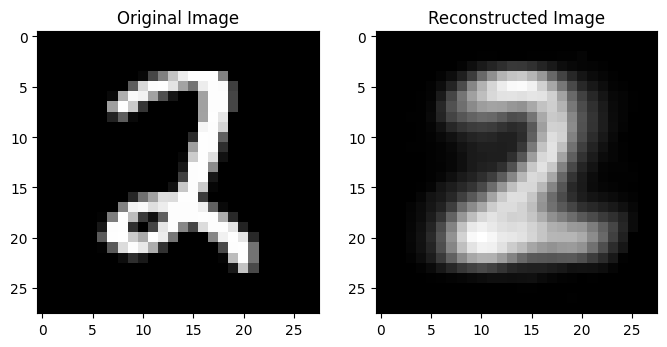

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random


# Set the model to evaluation mode
autoencoder.eval()

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=32, shuffle=True)

# Encode and reconstruct a random data sample
random_sample = random.choice(mnist_dataset)
original_image, _ = random_sample
original_image = original_image.view(1, -1)
reconstructed_image = autoencoder(original_image).view(28, 28)

# Plot the original and reconstructed images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image.view(28, 28).numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image.detach().numpy(), cmap='gray')

plt.show()



# Kmean clustreing

## Encoded data

In [7]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score


trained_encoder= autoencoder.encoder
trained_encoder.eval()

# Define a function to encode the data using the trained encoder
def encode_data(encoder, data_loader):
    encoded_data = []
    for data in data_loader:
        inputs, _ = data
        with torch.no_grad():
            encoded = encoder(inputs.view(inputs.size(0), -1)).cpu().numpy()
        encoded_data.append(encoded)
    return np.vstack(encoded_data)

train_encoded_data = encode_data(trained_encoder, train_loader)
valid_encoded_data = encode_data(trained_encoder, valid_loader)

# Merge the encoded training and validation data
merged_encoded_data = np.vstack((train_encoded_data, valid_encoded_data))

# Apply K-Means clustering
num_clusters = 10  # Assuming you want to cluster into 10 classes (for MNIST)
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels_encode = kmeans.fit_predict(merged_encoded_data)

# Evaluate the clustering using adjusted Rand index (ARI) and adjusted mutual information (AMI)
true_labels = [label for _, label in train_data] + [label for _, label in valid_data]
ari = adjusted_rand_score(true_labels, cluster_labels_encode)

print(f'Adjusted Rand Index (ARI): {ari:.4f}')


Adjusted Rand Index (ARI): 0.0230


## Raw Data

In [8]:
from sklearn.metrics import explained_variance_score, silhouette_score, pairwise_distances_argmin_min
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

merged_data = torch.utils.data.ConcatDataset([train_data, valid_data])

# Extract the images and labels
images, labels = zip(*merged_data)

# Convert images to NumPy array
images = np.array([img.numpy().flatten() for img in images])

# Apply K-Means clustering to the raw data
num_clusters = 10  # Assuming you want to cluster into 10 classes (for MNIST)
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
cluster_labels = kmeans.fit_predict(images)

# Calculate the Adjusted Rand Index (ARI)
true_labels = [label for _, label in merged_data]
ari = adjusted_rand_score(true_labels, cluster_labels)

print(f'Adjusted Rand Index (ARI): {ari:.4f}')


Adjusted Rand Index (ARI): 0.3607


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Calculate silhouette score
silhouette = silhouette_score(images, true_labels)
print("Silhouette Score of main data:", silhouette)

silhouette = silhouette_score(merged_encoded_data, true_labels)
print("Silhouette Score of AE output data with true labels:", silhouette)

silhouette = silhouette_score(merged_encoded_data, cluster_labels_encode)
print("Silhouette Score of AE output data with cluster labels:", silhouette)
print()
# Calculate Calinski-Harabasz index
calinski_harabasz = calinski_harabasz_score(images, true_labels)
print("Calinski-Harabasz Index of main data:", calinski_harabasz)

calinski_harabasz = calinski_harabasz_score(merged_encoded_data, true_labels)
print("Calinski-Harabasz Index of AE output data with true labels:", calinski_harabasz)

calinski_harabasz = calinski_harabasz_score(merged_encoded_data, cluster_labels_encode)
print("Calinski-Harabasz Index of AE output data with cluster labels:", calinski_harabasz)

print()

# Calculate Davies-Bouldin index
davies_bouldin = davies_bouldin_score(images, true_labels)
print("Davies-Bouldin Index of main data:", davies_bouldin)

davies_bouldin = davies_bouldin_score(merged_encoded_data, true_labels)
print("Davies-Bouldin Index of AE output data with true labels:", davies_bouldin)

davies_bouldin = davies_bouldin_score(merged_encoded_data, cluster_labels_encode)
print("Davies-Bouldin Index of AE output data with cluster labels:", davies_bouldin)
